In this notebook, I use the basic CNN architecture to recognise digits in the MNIST dataset. I am predominantly going of the information contained in Coursera's deep learning and TensorFlow developer specialisations, as well as Chapter 14 of 'Hands on Machine Learning'. In this notebook, we us the LeNet-5 architecture, which is the oldest and perhaps the most famous CNN architecture, before expanding on this to get a better prediction. We also use data augmentation to effectively increase the amount of training data we have. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')




train_data = pd.read_csv("digit-recognizer/train.csv")
test_data = pd.read_csv("digit-recognizer/test.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train_data = train_data.copy()
test_data = test_data.copy()


2024-08-06 08:54:44.788012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(train_data.isnull().any().describe())
print(test_data.isnull().any().describe())
#No missing data to impute

count       785
unique        1
top       False
freq        785
dtype: object
count       784
unique        1
top       False
freq        784
dtype: object


In [3]:
labels = train_data['label']
train_data.drop('label', axis = 1, inplace = True)
print(train_data.shape)


(42000, 784)


We can see that each instance in the training data is 784 pixels, which we interpret as an image with 28 x 28 pixes. We want this as a (28, 28, 1) - tensor, where the first two entries refer to the pixel, and the last entry to its greyscale value. This takes values between 0 and 255, and so we rescale to between 0 and 1 to make things easier. I think that it would still work if we didn't rescale, but it might make the process slower.

In [4]:
train_data /= 255.
test_data /= 255.
train_data = train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
print(train_data.shape)
# Note that we have converted the dataframes into np arrays.

(42000, 28, 28, 1)


When we make our NN, the last layer will be a softmax layer of ten nodes, each of which corresponding to a digit 0-9. We will take the prediction as the node which has the highest activation, and this is most naturally recorded as a 10-dimensional row vector with zeros everywhere except in one position. Currently, our label data has entries like '4', and we want to turn this into row vector of the above form, so, for example [0,0,0,0,1,0,0,0,0,0] for 4. 

The above conversion is precisely what to_categorical is for in the keras.utils library. 

In [5]:
labels = tf.keras.utils.to_categorical(labels, num_classes=10)
# Note that this is now also a np array. 
print(labels.shape)

(42000, 10)


We now split our data into train and test sets. Admittedly, it is a little confusing since I have also called the unlabelled data the test set, but I'm not able to use this data to validate my model -- this is unseen data. What I mean here by test set is a subset of the training data which will not be trained on and I will only use at the end to measure performance. This is different from the validation set, which is also a subset of the training set which is not used to train, with the key difference being that I measure performance against the validation set after each epoch. The reason I need both sets is to avoid overfitting by tuning the model to perform well on the validation set. 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

X_train, X_test, Y_train, Y_test = train_test_split(train_data, labels, test_size=0.1, random_state = 42)

# Following the architecture from table 14.1 of 'Hands on Machine Learning', but with relu not tanh and maxpooling rather than average pooling.

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)), 
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])


In [7]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 10, validation_split = 0.9, batch_size = 50)

model.summary()

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.4432 - loss: 1.6281 - val_accuracy: 0.9132 - val_loss: 0.2830
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.9230 - loss: 0.2408 - val_accuracy: 0.9249 - val_loss: 0.2306
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - accuracy: 0.9593 - loss: 0.1260 - val_accuracy: 0.9607 - val_loss: 0.1308
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.9670 - loss: 0.0910 - val_accuracy: 0.9678 - val_loss: 0.1050
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.9867 - loss: 0.0444 - val_accuracy: 0.9644 - val_loss: 0.1174
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.9913 - loss: 0.0328 - val_accuracy: 0.9621 - val_loss: 0.1274
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.9904 - loss: 0.0273 - val_accuracy: 0.9628 - val_loss: 0.1214
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 298ms/step - accuracy: 0.9949 - loss: 0.0211 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,728 (1.91 MB)

 Trainable params: 167,242 (653.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 334,486 (1.28 MB)

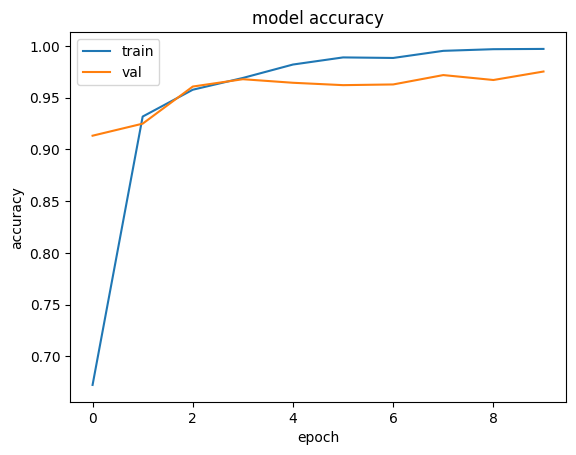

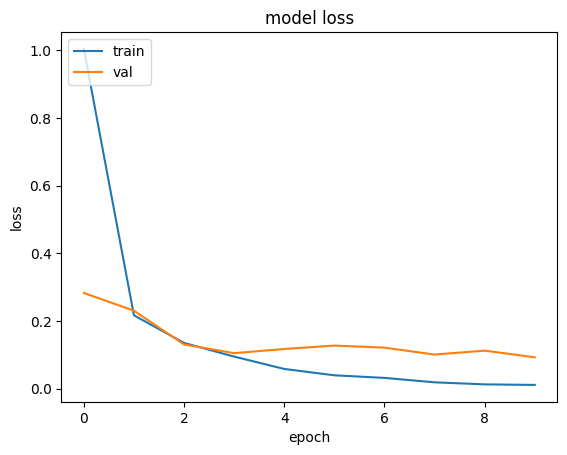

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

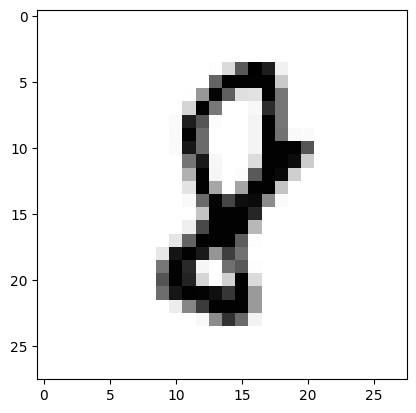

In [9]:
plt.imshow(X_test[0].reshape(28,28), cmap='Greys')
#Printing out some images to see what they look like and what the model predicts.

In [10]:
pred = model.predict(X_test[0].reshape(1, 28, 28, 1 ))
print(pred.argmax())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
8


In [11]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis = 1)
Y_test_numeric = np.argmax(Y_test, axis =1) # Turn it back into a number

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [12]:
print(confusion_matrix(predictions, Y_test_numeric))

[[405   0   1   1   0   0   9   0   1   1]
 [  0 468   0   0   0   0   0   2   2   0]
 [  0   2 411   2   0   0   0   5   4   1]
 [  0   1   1 489   0   3   0   0   4   2]
 [  0   0   3   0 390   0   1   2   1   0]
 [  1   0   0   9   0 332   2   0   6   3]
 [  2   0   0   0   2   1 390   0   1   0]
 [  0   0   3   2   2   1   0 425   1   2]
 [  0   0   1   1   0   1   0   1 381   0]
 [  0   0   0   2   3   1   0   3   2 407]]


There doesn't seem to be any systematic error which could be focused on to greatly improve performance, but the classifier does seem to have some problems with $9$'s.

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test_numeric, predictions))

0.9757142857142858


In [14]:
submission = model.predict(test_data)
submission = np.argmax(submission, axis = 1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step


In [15]:
my_submission = pd.DataFrame({'ImageId': [i for i in range(1,len(test_data)+1)], 'Label': submission})
my_submission.to_csv('LeNet-5.csv', index = False)


This got .96046 when submitted to Kaggle. This isn't bad, but we can certainly do better. For one thing, the separation between the training and validation accuracy seems to indicate some overfitting. We can seek to remedy this by augmenting the data. I essentially just want the images to be distorded and a little bit rotated. I don't want flipping, since numbers are not symmetric. Worse, I could get a different number if I flip it, which would cause issues in training if I expect the model to recognise a flipped six as a six in contrast to a nine. 

In [16]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False) 

datagen.fit(X_train)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)), 
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])
#Redefine model so that I am not just continuing to train the previous model with augmented data. Maybe that would be a good idea though.


In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1) # Manually create train and val data from the train data.
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(datagen.flow(X_train,Y_train, batch_size=100), validation_data = (X_val,Y_val), epochs = 20)

Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - accuracy: 0.6950 - loss: 0.9348 - val_accuracy: 0.9587 - val_loss: 0.1279
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 111s 217ms/step - accuracy: 0.9524 - loss: 0.1513 - val_accuracy: 0.9823 - val_loss: 0.0682
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 43s 123ms/step - accuracy: 0.9686 - loss: 0.1028 - val_accuracy: 0.9817 - val_loss: 0.0680
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.9751 - loss: 0.0800 - val_accuracy: 0.9810 - val_loss: 0.0622
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - accuracy: 0.9814 - loss: 0.0641 - val_accuracy: 0.9857 - val_loss: 0.0530
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.9818 - loss: 0.0596 - val_accuracy: 0.9862 - val_loss: 0.0505
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.9835 - loss: 0.0539 - val_accuracy: 0.9854 - val_loss: 0.0495
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step - accuracy: 0.9844 - loss: 0

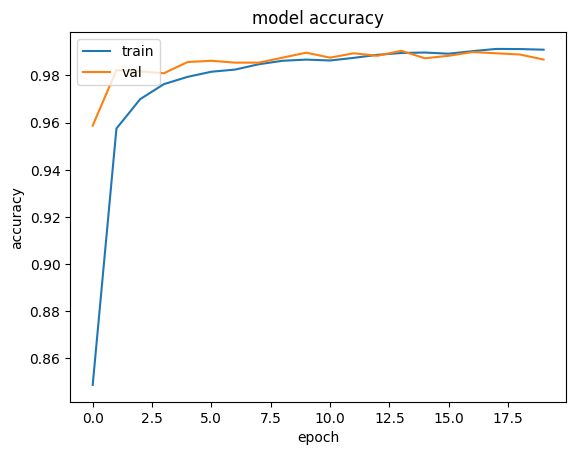

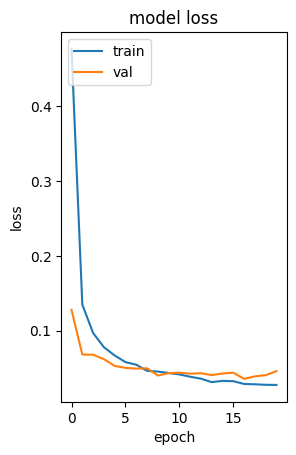

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis = 1)
Y_test_numeric = np.argmax(Y_test, axis = 1) # Turn it back into a number
print(confusion_matrix(predictions, Y_test_numeric))
print(accuracy_score(Y_test_numeric, predictions))

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
[[402   0   1   0   0   0   0   0   0   0]
 [  0 467   0   1   0   0   0   1   0   0]
 [  0   2 417   1   0   0   0   3   1   0]
 [  0   0   0 502   0   0   0   0   0   0]
 [  0   0   0   0 395   0   0   2   1   0]
 [  0   0   0   2   0 331   0   0   1   0]
 [  3   1   0   0   0   6 402   0   1   0]
 [  1   1   1   0   0   0   0 432   1   1]
 [  1   0   1   0   0   1   0   0 398   1]
 [  1   0   0   0   2   1   0   0   0 414]]
0.9904761904761905


In [21]:
#Train on all available data now.
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(datagen.flow(train_data,labels, batch_size=100), validation_data = (X_val,Y_val), epochs = 20, verbose = 0)

In [22]:
submission = model.predict(test_data)
submission = np.argmax(submission, axis = 1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


In [23]:
my_submission = pd.DataFrame({'ImageId': [i for i in range(1,len(test_data)+1)], 'Label': submission})
my_submission.to_csv('LeNet-5.csv', index = False)

This scored 0.99367 on Kaggle, which I think is a pretty good score! We might be able to push it higher, but I believe that Bayes' error is $0.26\%$, so there would be diminishing returns in doing so. It might be possible to impove it simply by training for more epochs, although it does seem like there is a slight downturn in validation accuracy towards the end of training. 